# CS 412 Term Project
## WALL-E

In [10]:
pip install autogluon pandas

In [11]:
pip install autogluon

In [31]:
import pandas as pd
import numpy as np
from autogluon.tabular import TabularPredictor
import random
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, ConfusionMatrixDisplay, RocCurveDisplay, precision_recall_curve, average_precision_score, PrecisionRecallDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import auc

In [32]:
# Function to augment text data by shuffling words
def augment_text(text):
    words = text.split()
    random.shuffle(words)
    return ' '.join(words)

# Load the training data
train_data = pd.read_csv('bugs-train.csv')

# Rename column to 'bug_id' for consistency
train_data.rename(columns={'bug id': 'bug_id'}, inplace=True)

# Define the severity mapping
severity_mapping = {
    'enhancement': 1,
    'minor': 2,
    'normal': 3,
    'major': 4,
    'blocker': 5,
    'critical': 6
}

# Map severity to numerical values
train_data['severity'] = train_data['severity'].map(severity_mapping)

# Drop rows with NaN values in severity (including those from unmapped values like 'trivial')
train_data = train_data.dropna(subset=['severity'])

# Feature Engineering
# Create a new feature for the length of the summary
train_data['summary_length'] = train_data['summary'].apply(len)

# Create a new feature for the number of words in the summary
train_data['summary_word_count'] = train_data['summary'].apply(lambda x: len(x.split()))

# Data Augmentation: Duplicate data with slight modifications
augmented_data = train_data.copy()
augmented_data['summary'] = augmented_data['summary'].apply(augment_text)
augmented_data['summary_length'] = augmented_data['summary'].apply(len)
augmented_data['summary_word_count'] = augmented_data['summary'].apply(lambda x: len(x.split()))

# Combine the original and augmented data
train_data = pd.concat([train_data, augmented_data], ignore_index=True)
train_data = train_data.drop(['bug_id'], axis=1)


In [33]:
# Increase the time limit
time_limit_seconds = 1800  # Set your desired time limit in seconds
print(f"Setting training time limit to {time_limit_seconds} seconds")

hyperparameters = {
    'RF': {},  # Use default hyperparameters for RandomForest
}

predictor = TabularPredictor(label='severity').fit(
    train_data,
    hyperparameters=hyperparameters,
    time_limit=time_limit_seconds
)
# Evaluate the model on the training data (or use a separate validation set if available)
performance = predictor.evaluate(train_data)
print("Performance on training data:", performance)

# Load the test data
test_data = pd.read_csv('bugs-test.csv')

# Rename column to 'bug_id' for consistency
test_data.rename(columns={'bug id': 'bug_id'}, inplace=True)

# Create the same features in the test data
test_data['summary_length'] = test_data['summary'].apply(len)
test_data['summary_word_count'] = test_data['summary'].apply(lambda x: len(x.split()))

# Ensure 'bug_id' is in the test data and treat it as an identifier
test_data = test_data.drop(['bug_id'], axis=1)

# Make predictions on the test data
test_data['severity'] = predictor.predict(test_data)

# Evaluate the model on the test data
eval = predictor.evaluate(test_data)
print("Evaluation on test data:", eval)

# Map numerical values back to severity labels
inverse_severity_mapping = {v: k for k, v in severity_mapping.items()}
test_data['severity'] = test_data['severity'].map(inverse_severity_mapping)

# Print the first few rows of the test data after predictions to debug
print("Test data after predictions:\n", test_data.head())

# Save the predictions to a file
test_data.to_csv('predictions.csv', index=False)

print("Predictions saved to predictions.csv")

No path specified. Models will be saved in: "AutogluonModels/ag-20240605_192751"
No presets specified! To achieve strong results with AutoGluon, it is recommended to use the available presets.
	Recommended Presets (For more details refer to https://auto.gluon.ai/stable/tutorials/tabular/tabular-essentials.html#presets):
	presets='best_quality'   : Maximize accuracy. Default time_limit=3600.
	presets='high_quality'   : Strong accuracy with fast inference speed. Default time_limit=3600.
	presets='good_quality'   : Good accuracy with very fast inference speed. Default time_limit=3600.
	presets='medium_quality' : Fast training time, ideal for initial prototyping.
Beginning AutoGluon training ... Time limit = 1800s
AutoGluon will save models to "AutogluonModels/ag-20240605_192751"
=================== System Info ===================
AutoGluon Version:  1.1.0
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Sun Apr 28 

Setting training time limit to 1800 seconds


	Available Memory:                    7610.98 MB
	Train Data (Original)  Memory Usage: 41.60 MB (0.5% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
		Fitting CategoryFeatureGenerator...
			Fitting CategoryMemoryMinimizeFeatureGenerator...
		Fitting TextSpecialFeatureGenerator...
			Fitting BinnedFeatureGenerator...
			Fitting DropDuplicatesFeatureGenerator...
		Fitting TextNgramFeatureGenerator...
			Fitting CountVectorizer for text features: ['summary']
			CountVectorizer fit with vocabulary size = 10000
		Reducing Vectorizer vocab size from 10000 to 653 to avoid OOM error
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Types o

Performance on training data: {'accuracy': 0.9264361373855435, 'balanced_accuracy': 0.5579009134394174, 'mcc': 0.7778139542601094}
Evaluation on test data: {'accuracy': 1.0, 'balanced_accuracy': 1.0, 'mcc': 1.0}
Test data after predictions:
                                              summary  summary_length  \
0  Firefox claims to be not the default browser w...             104   
1  Background of html and body element are not ap...              82   
2  Mouse input breaks after using window.showModa...              74   
3  Build failure with next freetype version/curre...              59   
4  HTML element is not treated as root inside for...              56   

   summary_word_count severity  
0                  14   normal  
1                  12   normal  
2                  10   normal  
3                   8   normal  
4                   9   normal  
Predictions saved to predictions.csv


In [34]:

prediction_data = pd.read_csv('predictions.csv')
prediction_data.head()
prediction_data.columns

Index(['summary', 'summary_length', 'summary_word_count', 'severity'], dtype='object')

In [35]:
prediction_data.drop(['summary','summary_length','summary_word_count'], inplace=True, axis=1)
test = pd.read_csv('bugs-test.csv')
test.drop(['summary'],inplace = True, axis=1)
combined_df = pd.concat([test, prediction_data], axis=1)
combined_df.to_csv('final_prediction.csv', index=False)

Performance on training data: {'accuracy': 0.9264361373855435, 'balanced_accuracy': 0.5579009134394174, 'mcc': 0.7778139542601094}
Confusion Matrix:
 [[  2319      0   6527      0      0      6]
 [     0   1902   4292      0      0     10]
 [     0      2 250051     14      0   1641]
 [     0      0   6255   5526      0    325]
 [     0      0    677      0    592    133]
 [     0      0   3467     14      0  33835]]


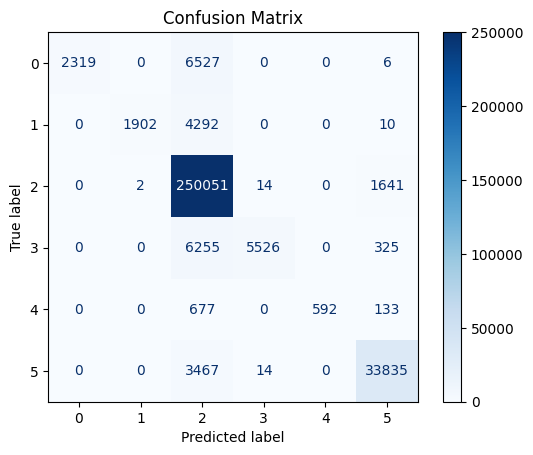

In [36]:
performance = predictor.evaluate(train_data)
print("Performance on training data:", performance)

# Generate confusion matrix on training data
y_true = train_data['severity']
y_pred = predictor.predict(train_data)
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


ROC AUC Score: 0.9971234963149853


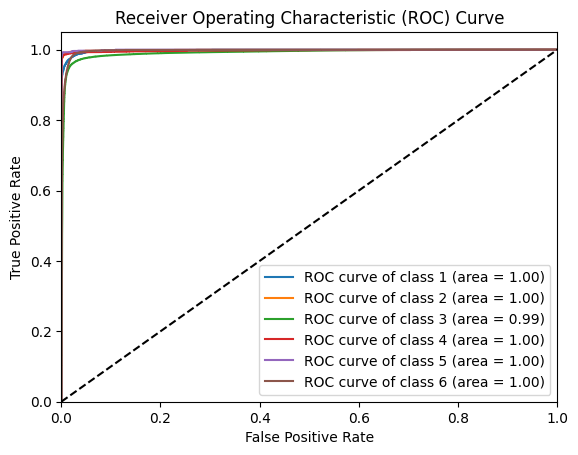

In [41]:
y_prob = predictor.predict_proba(train_data).to_numpy()
roc_auc = roc_auc_score(y_true, y_prob, multi_class='ovr')
print("ROC AUC Score:", roc_auc)

# Compute ROC curve and ROC area for each class
fpr = {}
tpr = {}
roc_auc = {}
for i in range(len(severity_mapping)):
    fpr[i], tpr[i], _ = roc_curve(y_true, y_prob[:, i], pos_label=i+1)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure()
for i in range(len(severity_mapping)):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve of class {i+1} (area = {roc_auc[i]:0.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()